In [4]:
import obspy
import os
import matplotlib.pyplot as plt
from numpy import diff
import numpy as np
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras

In [84]:
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd
from sklearn.metrics import confusion_matrix

In [5]:
signalpath = os.getcwd() + r'/data/signal/'
noisepath = os.getcwd() + r'/data/noise/'


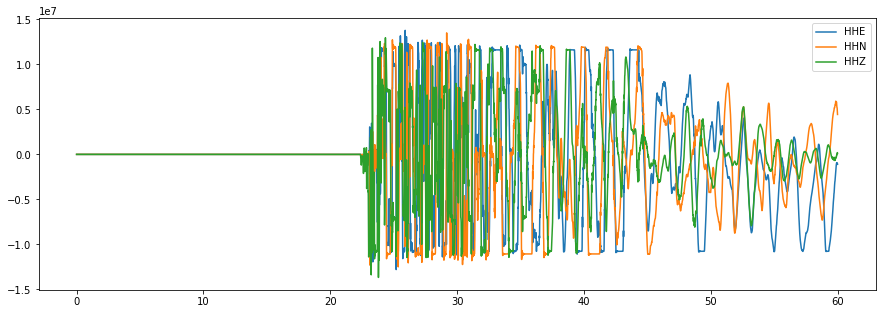

In [4]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("INGV")

t = UTCDateTime(2009, 4, 6, 1, 32)
stream = client.get_waveforms(network="MN", station="AQU", location="*", channel="HH?", starttime=t+20, endtime=t+80)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

In [5]:
stream

3 Trace(s) in Stream:
MN.AQU..HHE | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHN | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHZ | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples

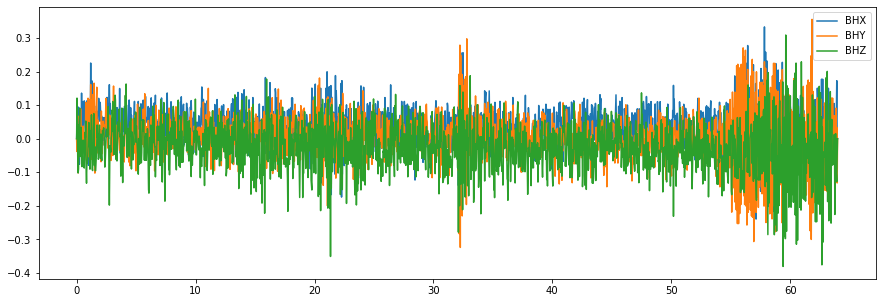

In [55]:
stream = obspy.read('data/signal/1512130231_005_P.mseed')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()


In [7]:
stream

3 Trace(s) in Stream:
.005..BHX | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHY | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHZ | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples

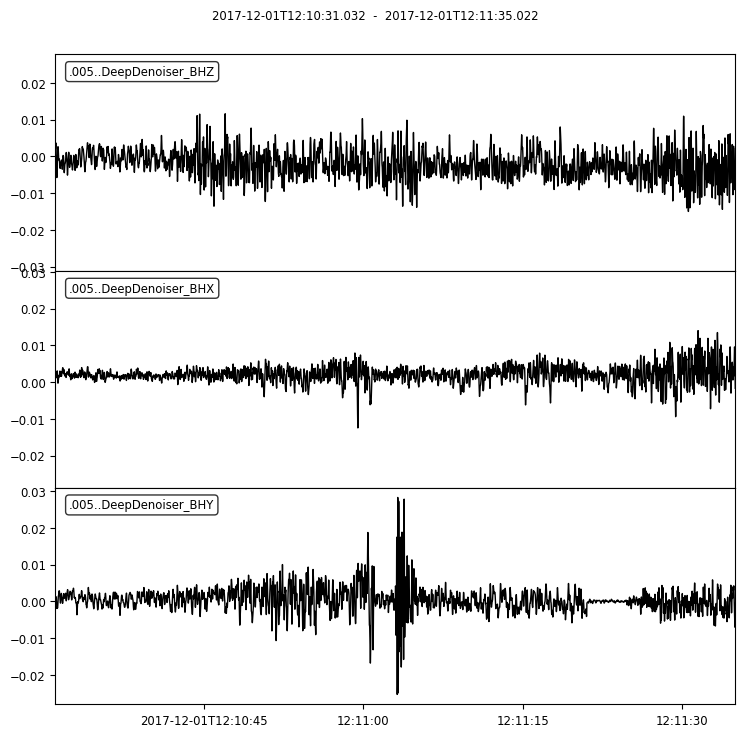

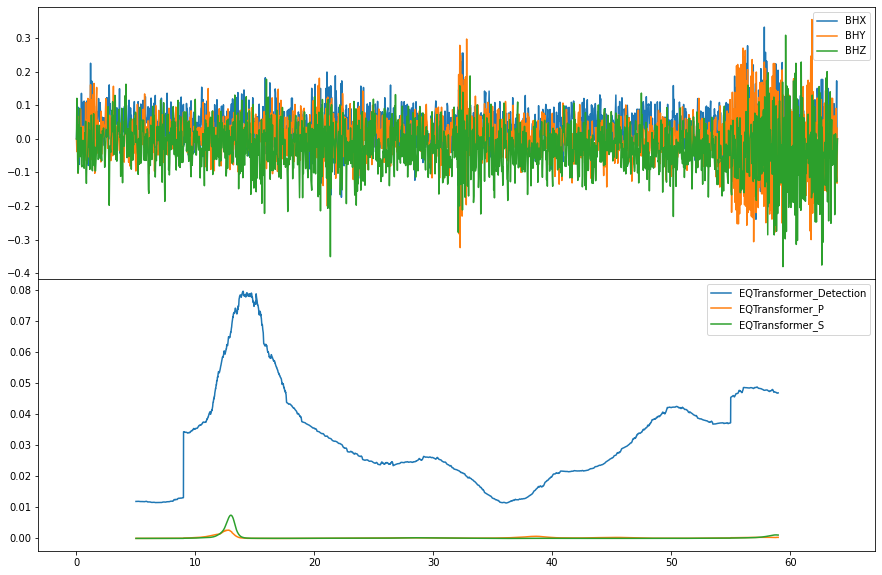

In [8]:
model = sbm.DeepDenoiser.from_pretrained("original")
annotations = model.annotate(stream)
annotations.plot()

picker = sbm.EQTransformer.from_pretrained("stead")

annotations = picker.annotate(annotations,strict=False)
annotations

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [7]:
signalfiles = [f for f in listdir(signalpath) if isfile(join(signalpath, f))]
noisefiles = [f for f in listdir(noisepath) if isfile(join(noisepath, f))]

In [69]:
stream = obspy.read('data/signal/1512130231_005_P.mseed')
sampling_rate = stream[0].stats['sampling_rate']
startidx = int(1000 - 2 * sampling_rate)
endidx = int(1100 - 2 * sampling_rate)
signaldata= [obspy.read(signalpath + signalfiles[i]) for i in range(len(signalfiles))] 
signal = np.array([[signaldata[i][0].data, signaldata[i][1].data, signaldata[i][2].data] for i in range(len(signaldata))])
noisedata = [obspy.read(noisepath + noisefiles[i]) for i in range(len(noisefiles))] 
noise = np.array([[noisedata[i][0].data, noisedata[i][1].data, noisedata[i][2].data] for i in range(len(noisedata))])
data = np.concatenate((signal[:,:, startidx:endidx], noise[:,:, startidx:endidx])).reshape(data.shape[0],-1)
target = np.array([1 for i in range(len(signal))]+[0 for i in range(len(noise))])

In [70]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(0, len(data)), int(len(data)*0.9))
train_data = data[train_idx]
train_y = target[train_idx]
test_data = data[~np.isin(np.arange(len(data)), train_idx)]
test_y = target[~np.isin(np.arange(len(target)), train_idx)]

In [89]:
my_init = keras.initializers.glorot_uniform(seed=1)

model = keras.Sequential([
    # Input layer, do not change
    tf.keras.layers.InputLayer(input_shape=(train_data.shape[1])),
    # Inner layers, can add/change
    keras.layers.Dense(32,  activation='tanh'),
    keras.layers.Dense(16,  activation='tanh',kernel_initializer=my_init),
    keras.layers.Dense(8,  activation='tanh',kernel_initializer=my_init),
    # Output layer, do not change
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    # Optimization algorithm, specify learning rate
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    # Loss function for a binary classifier
    loss='binary_crossentropy',
    # Diagnostic quantities
    metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                9632      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit(train_data, train_y, epochs = 200, batch_size = 64)

Epoch 1/200
269/269 [==============================] - 1s 3ms/step - loss: 0.1679 - accuracy: 0.9493
Epoch 2/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0878 - accuracy: 0.9802
Epoch 3/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0491 - accuracy: 0.9883
Epoch 4/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0310 - accuracy: 0.9918
Epoch 5/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0218 - accuracy: 0.9941
Epoch 6/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0141 - accuracy: 0.9963
Epoch 7/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0134 - accuracy: 0.9957
Epoch 8/200
269/269 [==============================] - 1s 4ms/step - loss: 0.0077 - accuracy: 0.9979
Epoch 9/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 10/200
269/269 [==============================] - 1s 2ms/step - loss: 0.0053 - accura

KeyboardInterrupt: 

In [91]:
pred = model.predict(test_data) >= 0.5
confusion_matrix(test_y,pred)

array([[7195,   16],
       [ 108,  390]])